In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [2]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [3]:
# load packages
using BenchmarkTools, DataFrames, Distributions, DynamicHMC, DynamicHMC.Diagnostics, 
    LinearAlgebra, MCMCChains, LogDensityProblems,
    Parameters, Profile, ProximalOperators,
    Random, Revise, Roots, SparseArrays, Statistics, DelimitedFiles, Test, DelimitedFiles, RCall
import ProximalOperators: prox, prox!

In [4]:
using StatsPlots
gr(size=(400, 400))

Plots.GRBackend()

# Proximal MCMC for graphical lasso

### Helper functions

In [5]:
function diagonal_index(p:: Int64)
    out = [1]
    @inbounds for j in 2:p
        out = vcat(out, [out[j-1] + (p - (j-2))])
    end
    out
end

"""
    vech!(v::AbstractVector, A::AbstractVecOrMat)
Overwrite vector `v` by the entries from lower triangular part of `A`. 
"""
function vech!(v::AbstractVector, A::AbstractVecOrMat)
    m, n = size(A, 1), size(A, 2)
    idx = 1
    @inbounds for j in 1:n, i in j:m
        v[idx] = A[i, j]
        idx += 1
    end
    v
end

"""
    vech(A::AbstractVecOrMat) -> AbstractVector
Return the entries from lower triangular part of `A` as a vector.
"""
function vech(A::AbstractVecOrMat)
    m, n = size(A, 1), size(A, 2)
    vech!(similar(A, n * m - (n * (n - 1)) >> 1), A)
end

"""
    sum_abs_lowertri(x::Matrix)
Sum of the absolute values of the lower triangle excluding the diagonals.
"""
function sum_abs_lowertri(x :: AbstractMatrix{T}) where T <: Real
    n = size(x, 1)
    out = zero(T)
    for j in 1:n
        for i in (j+1):n
            out += abs(x[i, j])
        end
    end
    out        
end

"""
    mean_center_data!(data, meanvals)
Mean center data.

# Arguments 
- `data`: the data matrix
- `meanvals`: the mean vector
"""
function mean_center_data(data::AbstractMatrix{T}, meanvals::Vector{T}) where T <: Real
    p = length(meanvals)
    for j in 1:p
        data[:, j] .-= meanvals[j]
    end
    return data
end

"""
    L_to_Θ!(Θ, L, paras)
Translate L samples into Θ. To be used by the get_Θ() function.

# Arguments 
- `Θ`: a matrix for storing Θ
- `L`: a matrix for storing L
- `paras`: a sample vector
"""
function L_to_Θ!(Θ::AbstractMatrix{T}, L::AbstractMatrix{T}, paras::Vector{T}) where T <: Real
    p = size(Θ, 1)
    fill!(L, 0)
    offset = 1
    @inbounds for j in 1:p
        L[j, j] = exp(paras[offset])
        offset += 1
        @inbounds for i in j+1:p
            L[i, j] = paras[offset]
            offset += 1
        end
    end
    mul!(Θ, L, transpose(L))
    
    return Θ
end

"""
    get_Θ(x, p)
Translate L samples into Θ. 

# Arguments 
- `x`: a n-by-[((p*(p+1))>>1] matrix containing the HMC samples for the lower Chol factor of the precision matrix
- `p`: dimension of Θ

# Values
- `Θ_lowertri`: a matrix of the same dimensions as `x` containing the vectorized lower triangle of Θ
"""
function get_Θ(x::AbstractMatrix{T}, p::Int64) where T <: Real
    
    # initialize a matrix to store the lower tri of Θ
    Θ_lowertri = similar(x)
    # initialize Θ and L to avoid repeated allocation
    Θ = zeros(p, p)
    L = similar(Θ)
    
    # Translate L to Θ and store the lower triangular of Θ to Θ_lowertri
    @inbounds for i in 1:size(Θ_lowertri, 1)
        L_to_Θ!(Θ, L, x[i, :])
        @views vech!(Θ_lowertri[i, :], Θ)
        #copyto!(Θ_lowertri[i, :], vech(Θ))
    end
    
    return Θ_lowertri
end

"""
    get_ci(Θ_lowertri)
Get 95% credible intervals for Θ. 

# Arguments 
- `Θ_lowertri`: output from the function get_Θ()

# Values
- `cis`: an [((p*(p+1))>>1]-by-2 matrix of credible intervals for the lower triangle of Θ
"""
function get_ci(Θ_lowertri::AbstractMatrix{T}) where T <: Real
    m = size(Θ_lowertri, 2)
    cis = zeros(m, 2)
    for i in 1:m
        cis[i, :] = quantile(Θ_lowertri[:,i], [0.025, 0.975])
    end
    return cis
end

"""
    is_covered(Θtrue, posterior_sample, p)
Shows the truth, CIs, and whether the CI covers the truth

# Arguments 
- `Θtrue`: truth precision matrix
- `posterior_sample`: raw posterior sample (for the transformed L) from HMC. Will be fed to function get_Θ()
- `p`: truth precision matrix

# Values
- `res`: an [((p*(p+1))>>1]-by-4 matrix. Col1: truth; Col2-3: credible intervals, Col4: indicator for whether the CI covers the truth
"""
function is_covered(Θtrue::AbstractMatrix{T}, posterior_sample::AbstractMatrix{T}, p::Int64) where T <: Real
    cis = get_ci(get_Θ(posterior_sample, p))
    res = zeros(((p*(p+1))>>1), 4)
    res[:, 1] = vech(Θtrue)
    res[:, 2:3] = cis
    for i in 1:size(res, 1)
        # The fourth column shows whether the truth is covered by the CI
        res[i, 4] = ((res[i, 1] > res[i, 2]) & (res[i, 1] < res[i, 3])) ? 1 : 0
    end
    res
end

# Helper functions from R
R"""
vech <- function(x){
    res <- vector()
    m <- nrow(x)
    for(j in 1:m){
        res <- c(res, x[j:m, j])
    }
    res
}
"""

"""
    get_Θ1norm(x, p)
Translate L samples into Θ, and calculate the L1 norm of Θ, excluding the diagonals. 

# Arguments 
- `x`: a n-by-[((p*(p+1))>>1] matrix containing the HMC samples for the lower Chol factor of the precision matrix
- `p`: dimension of Θ

# Values
- `Θ1norm`: a vector storing the L1 norm of Θ samples
"""
function get_Θ1norm(x::AbstractMatrix{T}, p::Int64) where T <: Real
    nsamples = size(x, 1)
    Θ1norm = zeros(nsamples)
    # initialize Θ and L to avoid repeated allocation
    Θ = zeros(p, p)
    L = similar(Θ)
    # Translate L to Θ and store the lower triangular of Θ to Θ_lowertri
    @inbounds for i in 1:nsamples
        L_to_Θ!(Θ, L, x[i, :])
        Θ1norm[i] = 2 * sum_abs_lowertri(Θ)
    end
    return Θ1norm
end

get_Θ1norm

We first implement the projection to the $\ell_1$ norm epigraph $\{(y, t): \sum_{j \neq k}|y| \le t\}$. To project a point $(x,s)$, the key computation is to find the root of 
$$
\phi(\lambda) = \sum_{j \neq k}|S_{\lambda}(x)| - \lambda - s,
$$
where $S$ is the sof-thresholding operator. This can be achieved by bisection or the sum-of-max algorithm (Algorithm 2 of <http://proceedings.mlr.press/v48/wangh16.pdf>). Both have linear complexity.

In [6]:
"""
    ϕ(x::Matrix, λ)

Return the value `sum(abs, Sλ(x[1:end-1])) - λ - x[end]`.
"""
function ϕ(x1::AbstractMatrix{T}, x2::AbstractVector{T}, λ::T) where T <: Real
    out = zero(T)
    # Lower triangular only
    @inbounds for j in 1:size(x1, 2)
        @inbounds for i in (j+1):size(x1, 1)
            δi = abs(x1[i, j]) - λ
            out += δi > 0 ? abs(δi) : zero(T)
        end
    end
    out *= 2 # include the upper-triangular
    out -= λ + x2[1]
    out
end

ϕ

In [7]:
Random.seed!(123)
x1 = randn(10,10)
x1 = x1'x1
x2 = [15.]
λ0 = find_zero(λ -> ϕ(x1, x2, λ), (0, maximum(abs, x1)), Bisection())
λ_grid = range(0, stop = maximum(abs, x1), length = 100)
fλ = [ϕ(x1, x2, λ_grid[i]) for i in 1:length(λ_grid)];

Now we can implement the projector to the $\ell_1$ norm epigraph
$$
\text{prox}_{\chi_{\mathcal{E}}}(x, s) = \text{proj}_{\mathcal{E}}(x) = \begin{cases}
(x, s) & \sum_{j \neq k}|x| \le s \\
(S_{\lambda^\star}(x), s + \lambda^\star) & \sum_{j \neq k}|x| > s
\end{cases},
$$
where $\lambda^\star$ is the root of $\phi(\lambda)$.

In [8]:
struct NormL1Epigraph end

is_convex(f::NormL1Epigraph) = true
is_set(f::NormL1Epigraph) = true

function prox!(
        y1 :: AbstractMatrix{T}, 
        y2 :: AbstractVector{T},
        f  :: NormL1Epigraph, 
        x1 :: AbstractMatrix{T}, 
        x2 :: AbstractVector{T},
        γ  :: T = T(1.0)
    ) where T <: Real
    n = size(x1, 1)
    if isinf(x2[1]) || 2 * sum_abs_lowertri(x1) ≤ x2[1]
        copyto!(y1, x1)
        copyto!(y2, x2)
        return zero(T)
    end
    @views λ₀ = find_zero(λ -> ϕ(x1, x2, λ), (0, maximum(abs, x1)), Bisection())
    # Soft-thresholding of the lower triangle
    for j in 1:n
        for i in (j+1):n
            δi   = abs(x1[i, j]) - λ₀
            y1[i, j] = δi > 0 ? copysign(δi, x1[i, j]) : zero(T) 
        end
    end

    # Copy the lowertri to the uppertri 
    LinearAlgebra.copytri!(y1, 'L')
    # Copy the diagonal
    
    # Do we soft-threshold the diagonal or not?
    for i in 1:n
        y1[i, i] = x1[i, i]
    end
    
    copyto!(y2, x2 .+ λ₀)
    zero(T)
end

prox(f::NormL1Epigraph, x1::AbstractMatrix{T}, x2::AbstractVector{T}, γ::T = T(1.0)) where T<:Real = 
    prox!(similar(x1), similar(x2), f, x1, x2, γ)

prox (generic function with 4 methods)

In [9]:
# test it
Random.seed!(123)
x1 = randn(10, 10)
x1 = x1'x1
x2 = [1.5]
x1_prox = similar(x1)
x2_prox = similar(x2)
prox!(x1_prox, x2_prox, NormL1Epigraph(), x1, x2)
x1

10×10 Matrix{Float64}:
  5.47611   -1.07303   -0.424305  …   0.431788  -1.19516   -2.28973
 -1.07303    8.20339    3.00098       1.51678    3.81983    0.236509
 -0.424305   3.00098   16.599        -0.225516   1.50092    2.55154
 -1.43493    5.17749    8.7497       -2.48307    0.327413   0.721347
  2.96771    1.1195     1.05899       1.99756    1.79144    1.40104
  2.63478   -3.72744   -9.81359   …   1.18753   -2.36653   -3.29362
 -4.01291   -1.964     -7.29924      -2.82593   -1.22512    1.15285
  0.431788   1.51678   -0.225516      5.01944    1.02942   -0.203707
 -1.19516    3.81983    1.50092       1.02942    4.63542    1.29123
 -2.28973    0.236509   2.55154      -0.203707   1.29123    3.23459

In [10]:
x1_prox

10×10 Matrix{Float64}:
 5.47611  0.0       0.0        0.0      0.0      …  0.0      0.0      0.0
 0.0      8.20339   0.0        0.0      0.0         0.0      0.0      0.0
 0.0      0.0      16.599      1.57469  0.0         0.0      0.0      0.0
 0.0      0.0       1.57469   12.7097   0.0         0.0      0.0      0.0
 0.0      0.0       0.0        0.0      9.89893     0.0      0.0      0.0
 0.0      0.0      -2.63858    0.0      0.0      …  0.0      0.0      0.0
 0.0      0.0      -0.124234   0.0      0.0         0.0      0.0      0.0
 0.0      0.0       0.0        0.0      0.0         5.01944  0.0      0.0
 0.0      0.0       0.0        0.0      0.0         0.0      4.63542  0.0
 0.0      0.0       0.0        0.0      0.0         0.0      0.0      3.23459

In [11]:
# sanity check
2*sum_abs_lowertri(x1_prox), x2_prox[1]

(8.675010612985393, 8.675010612985393)

Define the graphical lasso problem.

In [12]:
struct GraphicalLassoProblem{T <: Real}
    X       :: Matrix{T} # n-by-p observation matrix
    S       :: Matrix{T}
    p       :: Int64
    λ       :: T         # Moreau-Yosida envelope parameter
    αprior  :: Tuple{T, T} # IG(r, s) prior for α
    Θ       :: Matrix{T}
    L       :: Matrix{T}
    α       :: Vector{T}
    Θ_prox  :: Matrix{T}
    α_prox  :: Vector{T}
    ∇L      :: Matrix{T}
    ∇       :: Vector{T}
end

In [13]:
# constructor
function GraphicalLassoProblem(X::Matrix{T}, λ::T, 
        αprior::Tuple{T, T}) where T <: Real
    S  = cov(X)
    p  = size(X, 2)
    Θ  = Matrix{T}(undef, p, p)
    L  = Matrix{T}(undef, p, p)
    α  = Vector{T}(undef, 1)
    Θ_prox = similar(Θ)
    α_prox = similar(α)
    ∇L = similar(Θ)
    ∇  = Vector{T}(undef, p*(p+1)>>1 + 1)
    GraphicalLassoProblem{T}(X, S, p, λ, αprior, Θ, L, α, Θ_prox, α_prox, ∇L, ∇)
end

GraphicalLassoProblem

In [14]:
"""
    modelpar_to_optimpar!(par)
Translate model parameters to optimization variables.
"""
function modelpar_to_optimpar!(paras::Vector, problem::GraphicalLassoProblem)
    copyto!(problem.L, Symmetric(problem.Θ))
    LAPACK.potrf!('L', problem.L)

    offset = 1
    @inbounds for j in 1:problem.p
        paras[offset] = log(problem.L[j, j]) 
        offset += 1
        @inbounds for i in j+1:problem.p
            paras[offset] = problem.L[i, j]
            offset += 1
        end
    end
    paras[offset] = log(problem.α[1])
    paras
end

modelpar_to_optimpar!

In [15]:
"""
    optimpar_to_modelpar!(paras)
Translate optimization variables into model parameters
"""
function optimpar_to_modelpar!(problem::GraphicalLassoProblem, paras::Vector)
    #copyto!(problem.paras, paras)
    fill!(problem.L, 0)
    offset = 1
    @inbounds for j in 1:problem.p
        problem.L[j, j] = exp(paras[offset])
        offset += 1
        @inbounds for i in j+1:problem.p
            problem.L[i, j] = paras[offset]
            offset += 1
        end
    end
    mul!(problem.Θ, problem.L, transpose(problem.L))

    problem.α[1] = exp(paras[offset])
    problem
end

optimpar_to_modelpar!

In [16]:
(problem::GraphicalLassoProblem)(paras) = LogDensityProblems.logdensity(problem, paras)

LogDensityProblems.capabilities(::Type{<:GraphicalLassoProblem}) =
    LogDensityProblems.LogDensityOrder{1}()

LogDensityProblems.dimension(problem::GraphicalLassoProblem) = (problem.p * (problem.p + 1)) >> 1 + 1

In [17]:
function LogDensityProblems.logdensity(problem::GraphicalLassoProblem, paras)
    optimpar_to_modelpar!(problem, paras)
    @unpack X, S, p, λ, αprior, Θ, L, α, Θ_prox, α_prox = problem
    logα    = paras[end]
    n      = size(X, 1)
    rα, sα  = αprior
    
    @inbounds for j in 1:p
        # the diag of chol may be <=0 due to numerical reasons. 
        # if this happens, set logl to be -Inf.
        if L[j, j] <= 1e-5
            logl = -Inf
            return logl
        end
    end
    
    # log-likelihood + log(prior), with constant terms dropped
    logl    = - (n/2) * dot(S, Θ) + n * sum(log.(diag(L))) - sα * logα - rα/α[1] + p * log(2)
    @inbounds for j in 1:p
        logl += (p-j+2) * L[j, j]
    end
    @show logl
    @show Θ
    prox!(Θ_prox, α_prox, NormL1Epigraph(), Θ, α)
    @show Θ_prox
    Θ_prox .= Θ .- Θ_prox
    @show Θ_prox
    α_prox .= α .- α_prox
    @show ( abs2(norm(Θ_prox)) + abs2(norm(α_prox)) ) / (2λ)
    logl   -= ( abs2(norm(Θ_prox)) + abs2(norm(α_prox)) ) / (2λ)
    logl
end

In [18]:
function LogDensityProblems.logdensity_and_gradient(problem::GraphicalLassoProblem{T}, paras) where T <: Real
    optimpar_to_modelpar!(problem, paras)
    @unpack X, S, p, λ, αprior, Θ, L, α, Θ_prox, α_prox = problem
    
    @inbounds for j in 1:p
        # the diag of chol may be <=0 due to numerical reasons. 
        # if this happens, set logl to be -Inf.
        if L[j, j] ≤ 1e-5
            logl = -Inf
            ∇ = zeros((p * (p+1)) >> 1 + 1)
            return logl, ∇
        end
    end
    
    n       = size(X, 1)
    logα    = paras[end]
    rα, sα  = αprior
    invλ    = inv(λ)
    logl    = - (n/2) * dot(S, Θ) + n * sum(log.(diag(L))) - sα * logα - rα/α[1] + p * log(2)
    @inbounds for j in 1:p
        logl += (p-j+2) * L[j, j]
    end
    ∇L      = -n*S*L + n*transpose(inv(L))
    
    # Projection to L1 norm epigraph
    prox!(Θ_prox, α_prox, NormL1Epigraph(), Θ, α)
    Θ_prox .= Θ .- Θ_prox
    α_prox .= α .- α_prox
    logl   -= ( abs2(norm(Θ_prox)) + abs2(norm(α_prox)) ) / (2λ)
    ∇L     -= 2*invλ * (Θ_prox * L)
    
    # Adding gradient that comes from the Jacobian
    @inbounds for j in 1:p
        ∇L[j, j] += p - j + 2
    end
    
    # Currently ∇L is w.r.t L
    # But we need gradient w.r.t log(L_jj) and L_ij, so we need to multiply the diagonal entries with L_jj
    @inbounds for j in 1:p
        # On the diagonal, gradient wrt log(L_jj)
        ∇L[j, j] *= L[j, j]
    end
    
    ∇logα   = -sα + rα/α[1] - invλ * α[1] * α_prox[1]
    ∇       = [vech(∇L); ∇logα]
    
    logl, ∇
end

## Run it on cytometry data

In [19]:
cytometry = readdlm("../data/cytometry.csv", ',');
proteinnames = cytometry[1, :];
cytoval = Float64.(cytometry[2:end, :]);
cytovalnew = mean_center_data(cytoval, vec(mean(cytoval, dims = 1)));
S = cov(cytovalnew)
V = diagm(diag(inv(S)));

In [20]:
p = 11
λ = 0.01 
αprior  = (1., p+1.) 
glp = GraphicalLassoProblem(cytovalnew, λ, αprior)
Θ₀ = V
α₀ = 2*sum_abs_lowertri(V)
copyto!(glp.Θ, Θ₀)
copyto!(glp.α, [α₀])
pars = zeros((glp.p*(glp.p+1))>>1 + 1)
modelpar_to_optimpar!(pars, glp);

In [21]:
#mcmc_with_warmup(Random.GLOBAL_RNG, glp, 10, reporter=NoProgressReport())
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, glp, 10_000, reporter=ProgressMeterReport());

  6.210167 seconds (27.28 M allocations: 4.227 GiB, 8.12% gc time, 65.29% compilation time)


In [22]:
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.89, 5/25/50/75/95%: 0.69 0.84 0.92 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 98%, 5 => 2%

In [23]:
results_matrix = transpose(results.posterior_matrix);

In [24]:
# ESS for θ
cov_matrix = cov(results_matrix[:, 1:(glp.p*(glp.p+1))>>1])
F = svd(cov_matrix)
v_strongest = F.V[:,1]
slowest = results_matrix[:, 1:(glp.p*(glp.p+1))>>1] * v_strongest;

In [25]:
chn_slowest = MCMCChains.Chains(slowest, ["θslowest"], thin = 1);

In [26]:
ess_slowest = ess_rhat(chn_slowest)

ESS
  parameters         ess      rhat 
      Symbol     Float64   Float64 

    θslowest   5327.8543    0.9999


In [27]:
# Get ProxMCMC credible intervals
cis_pm = get_ci(get_Θ(results_matrix[:, 1:(p*(p+1))>>1], p));

In [28]:
# Cross-validated graphical lasso
@rput cytovalnew
R"""
library("CVglasso")
# cvg <- CVglasso(cytovalnew, lam = c(10^{-20}, 10^{-10}, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100))
# CV is not stable. But roughly it chooses lam = 0.0001
cvg <- CVglasso(cytovalnew, lam = 0.0001)
precision_cv <- cvg$Omega
"""
@rget precision_cv
vech_precision_cv = vech(precision_cv);

In [29]:
# Bayesian Graphical Lasso
@rput cytovalnew
R"""
library(BayesianGLasso)
capture.output(bg <- BayesianGLasso::blockGLasso(X = cytovalnew, iterations = 11000, 
                lambdaPriora = 1, lambdaPriorb = 0.1, burnIn = 1000, verbose = F))
bg_res <- sapply(bg$Omegas[1001:11000], vech)
"""
@rget bg_res;
cis_bg = get_ci(transpose(bg_res));

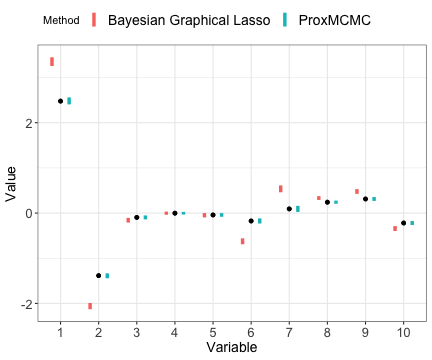

RObject{VecSxp}


In [30]:
@rput cis_bg
@rput cis_pm
@rput vech_precision_cv

R"""
library(magrittr)
library(dplyr)
library(ggplot2)

m <- 10
df <- data.frame(rbind(cis_bg[1:m, ], cis_pm[1:m, ]))
colnames(df) <- c("lower", "upper")
df$Variable <- rep(1:m, 2)
df$Method <- c(rep("Bayesian Graphical Lasso", m), rep("ProxMCMC", m))
df$cv_precision <- rep(vech_precision_cv[1:m], 2)
df %<>% within({
  Method <- factor(Method, levels = c("Bayesian Graphical Lasso", "ProxMCMC"))
  Variable <- factor(Variable)
})
dodge <- position_dodge(width=0.9)
ggplot(df, aes(Variable), dpi = 300) + 
  geom_linerange(aes(ymin = lower, ymax = upper, color = Method), position = dodge, size = 1.6) + 
  geom_point(aes(x = Variable, y = cv_precision)) + labs(y = "Value") + 
  theme_bw() + theme(legend.position="top",legend.justification="left") + 
  theme(axis.text=element_text(size=13), axis.title=element_text(size=14), legend.text = element_text(size=14))
#ggsave("../plots/graphical-lasso-cytometry.eps", dpi = 300)
"""

## Calculate % parameters covered by their CI

Note this is different from the coveraged probability, which requires simulating many independent data sets.

In [31]:
npars = size(cis_bg, 1)
cover_bg = zeros(npars)
cover_pm = similar(cover_bg);

In [32]:
for i in 1:npars
    if cis_bg[i, 1] < vech_precision_cv[i] < cis_bg[i, 2]
        cover_bg[i] = 1
    end
    if cis_pm[i, 1] < vech_precision_cv[i] < cis_pm[i, 2]
        cover_pm[i] = 1
    end
end

In [33]:
# Bayesian graphical lasso
sum(cover_bg)/length(cover_bg)

0.24242424242424243

In [34]:
# ProxMCMC
sum(cover_pm)/length(cover_pm)

1.0